# Intermediate Bioinformatics for Parkinson’s Disease Genetics

* __Module I:__  Genome-Wide Association Studies on Parkinson's disease progression. Part 2 - Cox models

* __Authors:__ Manuela Tan on behalf of the Global Parkinson's Genetics Program (GP2) from Aligning Science Across Parkinson's (ASAP)

* __Estimated Computation and Runtime:__
    * Estimated Specifications: 4 CPUs, 26 GB memory, 50 GB Persistent Disk
    * Estimated Runtime: 8.5 h total (2 h for notebook, 2.5 h for setting up Docker for the first time, 4 h for workflow with 150GB memory and 8 CPUs for each task)
    
* __Date last updated:__ 25-JUL-2022
    * Update Description: Removed SNP duplicates from genetic data otherwise problems with workflow and joining datasets

## Quick Description:

This notebook sets up to run a progression GWAS using Cox proportional hazards models for a longitudinal binary outcome, in this case, the Hoehn and Yahr stage 3 or greater. This notebook demonstrates how the GWAS Cox proportional hazards model is run using a sample of 20 SNPs. The GWAS itself is run using a Terra Workflow, which scales up the same method to the whole genome.

## Background/Motivation:

Genome-wide association studies (GWASs) are a method to test common genetic variants across the genome. In Parkinson's disease (PD), there have been a number of large GWASs comparing PD cases to controls to identify variants associated with disease risk. 

However, it is also important to study the genetics and biology of disease progression. We are now able to do this with increasing data available from longitudinal PD studies with detailed clinical data. By conducting progression GWASs on PD cases only, we can study the association between genetic variants and rate of progression, or other PD phenotypes. These studies can provide insight into genetic variants, genes, and pathways which might influence the rate of progression and could be targeted to develop new disease-modifying treatments.

There are different ways to measure and analyse progression, for example, depending on whether the outcome is continuous or binary (yes/no). Here we are using Cox proportional hazards models to analyse a longitudinal binary outcome.

## Workflow Summary:

0. Getting started
1. Calculate genetic principal components
2. Set up for R within Python notebook
3. Cox proportional hazards models
4. Set up for workflow
5. Run workflow (outside notebook)
6. Look at results

## Workflow:

### [0. Getting Started](#0)

This section goes through:
* Setting up Python libraries, data path variables, and functions
* Installing plink
* Copying data to workspace
* Look at format of clinical data
* Basic QC of genetic data

### [1. Calculate genetic principal components](#1)

This section goes through:
* Importing non-imputed genetic data into the workspace
* Run basic QC on non-imputed data
* Calculate genetic principal components on pruned SNPs

### [2. Set up for R within Python notebook](#2)

This section goes through:
* Installing rpy2
* Installing R packages

### [3. Cox proportional hazards models](#3)

This section goes through:
* Extract first 20 SNPs as a test subset
* Run Cox model on one SNP and model outputs
* Make function to run Cox models on many SNPs
* Run Cox models on test 20 SNPs

### [4. Scale to whole genome](#4)

This section goes through:
* Splitting genetic data into subsets of 20k SNPs
* Export necessary data to workspace bucket

### [5. Run workflow](#5)

This is not run in the notebook, but using the Terra workflow. However I have linked some Terra guides and outlined the steps involved to run a workflow.

* Make Docker
* WDL
* Run workflow

### [6. Look at workflow results](#6)

This section goes through:
* Importing results from the workflow into the notebook
* Tidying GWAS results

## 0. Getting started
<a id="0"></a>

### Set up libraries

Set up cells copied from the GP2 Beginners Bioinformatics course, https://github.com/GP2-TNC-WG/GP2-Bioinformatics-course/blob/master/Introduction.md

In [ ]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Import seaborn for plots
import seaborn as sns

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

### Set up billing project and data path variables

This includes the paths for the AMP-PD clinical and genetic data (version 2.5). Not needed for this demo but may be useful if you are working with AMP-PD data for your GWAS.

In [ ]:
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

GS_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
GS_CLINICAL_RELEASE_PATH = f'{GS_RELEASE_PATH}/clinical'

GS_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
GS_WGS_RELEASE_PLINK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'plink')
GS_WGS_RELEASE_GATK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'gatk')

BQ_RELEASE_DATASET = 'amp-pd-research.2021_v2_5release_0510'

print(BILLING_PROJECT_ID)
print(GS_CLINICAL_RELEASE_PATH)
print(GS_WGS_RELEASE_PLINK_PATH)
print(GS_WGS_RELEASE_GATK_PATH)

### Set up functions

In [ ]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}')
    !$command

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)
    
# Get the data from a query
def bq_query(query):
    """Return the contents of a query against BigQuery"""
    return pd.read_gbq(
        query,
        project_id=BILLING_PROJECT_ID,
        dialect='standard')

### Install plink (both plink1 and plink2)

Install plink1

In [ ]:
%%bash

if test -e /home/jupyter/plink; then

echo "Plink is already installed in /home/jupyter/"
else
echo "Plink is not installed"
cd /home/jupyter

wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 

unzip -o plink_linux_x86_64_20190304.zip

fi

Install plink2. Get most recent download link from https://www.cog-genomics.org/plink/2.0/

In [ ]:
%%bash

if test -e /home/jupyter/plink2; then

echo "Plink2 is already installed in /home/jupyter/"
else
echo "Plink2 is not installed"
cd /home/jupyter/

wget https://s3.amazonaws.com/plink2-assets/alpha3/plink2_linux_avx2_20220603.zip

unzip -o plink2_linux_avx2_20220603.zip

fi

### Copy 1000G clinical and genetic data to workspace

General tip: save data to your Persistent Disk (/home/jupyter/) - you can create directories within this. That way you can delete and recreate your Cloud Environment if there are any issues, and the data saved on the Persistent Disk will be retained. See: https://support.terra.bio/hc/en-us/articles/360047318551-Detachable-Persistent-Disks-

Genetic data is from the GP2 Beginners Bioinformatics course Module II - IMPUTED.HARDCALLS.Demo.bed, bim and fam files. These have been filtered for MAF > 0.001 and Rsq (imputation quality score) > 0.8. Check your genetic data, you may need to apply filters. Data is in genome build GRCh37.

In [ ]:
%%bash
#Make directories for genetic and clinical data if they do not already exist
mkdir -p /home/jupyter/1000G_genetic/
mkdir -p /home/jupyter/1000G_clinical/

First copy files into your workspace > Data > Files

In [ ]:
#Now import genetic files from the workspace bucket into the notebook workspace
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/IMPUTED.HARDCALLS.Demo_formatted.* /home/jupyter/1000G_genetic/')

In [ ]:
%%bash
ls /home/jupyter/1000G_genetic/
#Now you should see the 1000Genomes Demo data in this folder

In [ ]:
#Import clinical data files from the workspace bucket into the notebook workspace
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/DEMO_HY3.txt /home/jupyter/1000G_clinical/')

In [ ]:
#Import hg19 exclusion regions into the workspace
#From https://github.com/neurogenetics/GWAS-pipeline
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/exclusion_regions_hg19.txt /home/jupyter/1000G_genetic/')

### Look at clinical data

For Cox models, the data should be in wide format - there is only one row for each patient. You may need to do some data cleaning and formatting of your clinical dataset. I have also included other variables which may be included as covariates: age at onset. Gender is in the genetic data files.

In [ ]:
%%bash
cd /home/jupyter/1000G_clinical/
head DEMO_HY3.txt

In [ ]:
%%bash
tail /home/jupyter/1000G_clinical/DEMO_HY3.txt

### Format genetic data

**NOTE** The genetic dataset has phenotypes of cases and controls, but as this is a demonstration dataset and not real data, we are going to say these are all cases. The PD progression GWAS is run on cases only.

Rerun some basic quality control (this has already been done on the files but just to check).

In [ ]:
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_formatted \
            --maf 0.01 \
            --make-bed \
            --out /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01')

Remove duplicate SNPs, as otherwise this causes problems later if there are SNPs with duplicated names.

In [ ]:
shell_do(f'/home/jupyter/plink2 --bfile /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01 \
            --rm-dup force-first \
            --make-bed \
            --out /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli')

## 1. Make genetic principal components using non-imputed data (directly genotyped variants)
<a id="1"></a>

In [ ]:
#Import non-imputed genetic files from the workspace bucket into the notebook workspace
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/FILTERED.test_formatted.* /home/jupyter/1000G_genetic/')

In [ ]:
#Run some basic QC on the non-imputed genetic data
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/FILTERED.test_formatted \
            --maf 0.01 \
            --geno 0.05 \
            --hwe 1E-6 \
            --exclude range /home/jupyter/1000G_genetic/exclusion_regions_hg19.txt \
            --make-bed \
            --out /home/jupyter/1000G_genetic/FILTERED.test.qc')

In [ ]:
#Prune SNPs
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/FILTERED.test.qc \
            --indep-pairwise 50 5 0.5 \
            --out /home/jupyter/1000G_genetic/prune')

In [ ]:
#Keep only pruned SNPs
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/FILTERED.test.qc \
            --extract /home/jupyter/1000G_genetic/prune.prune.in \
            --make-bed \
            --out /home/jupyter/1000G_genetic/FILTERED.test.qc.pruned')

In [ ]:
#Run PCA on pruned SNPs
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/FILTERED.test.qc.pruned \
            --pca \
            --out /home/jupyter/1000G_genetic/PCA')

## 2. Set up for R within Python notebook
<a id="2"></a>

### Install rpy2 to run R in python

In [ ]:
#!pip install rpy2

In [ ]:
#Import rpy2
import rpy2.rinterface

In [ ]:
%load_ext rpy2.ipython

### Install R packages

In [ ]:
%%bash
mkdir -p /home/jupyter/R_packages
#Make directory R_packages if it does not already exist

In [ ]:
%%R
pack <- "/home/jupyter/R_packages"

#COMMENT OUT PACKAGES ALREADY INSTALLED

#install.packages("dplyr", lib = pack)
#install.packages("data.table", lib = pack)
#install.packages("tidyr", lib = pack)
#install.packages("survival", lib = pack)
#install.packages("survminer", lib = pack)
#install.packages("ggpubr", lib = pack)

In [ ]:
%%bash
head /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.fam

In [ ]:
%%bash
head /home/jupyter/1000G_genetic/PCA.eigenvec

In [ ]:
%%bash
head /home/jupyter/1000G_clinical/DEMO_HY3.txt

## 3. Cox proportional hazards models
<a id="3"></a>

### Extract first 20 SNPs

In [ ]:
%%bash
head -20 /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.bim

In [ ]:
#Extract just first few SNPs
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli \
            --from 1:693731 \
            --to 1:768448 \
            --recodeA \
            --out /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.test_snps.recodeA')

In [ ]:
#Check freq
shell_do(f'/home/jupyter/plink --bfile /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli \
            --from 1:693731 \
            --to 1:768448 \
            --freq \
            --out /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.test_snps.freq')

In [ ]:
%%bash
cat /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.test_snps.freq.frq

In [ ]:
%%bash
head /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.test_snps.recodeA.raw

### Cox model on one SNP

Make folder for results

In [ ]:
%%bash
mkdir -p /home/jupyter/progressionGWAS_results/cox

Load R packages

In [ ]:
%%R
pack <- "/home/jupyter/R_packages"
library(dplyr, lib.loc = pack)
library(ggplot2, lib.loc = pack)
library(data.table, lib.loc = pack)
library(tidyr, lib.loc = pack)
library(survival, lib.loc = pack)
library(ggpubr, lib.loc = pack)
library(survminer, lib.loc = pack)

Make merged dataset

In [ ]:
%%R

#Read in genetic data
genetic <- fread("/home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.test_snps.recodeA.raw")

#Read in PCs
PCs <- fread("/home/jupyter/1000G_genetic/PCA.eigenvec")
colnames(PCs) <- c("FID", "IID", paste0("PC", 1:20))

#Read in clinical data
clinical <- fread("/home/jupyter/1000G_clinical/DEMO_HY3.txt")

#Merge - make sure that your sample IDs in the genetic, PCs, and clinical data match or you may need to reformat
merged <- clinical %>%
inner_join(PCs, by = c("ID" = "FID")) %>%
inner_join(genetic, by = c("ID" = "IID"))

head(merged)

Run Cox proportional hazards model just on one SNP first

In [ ]:
%%R

#Check how many individuals have met or not met the outcome
merged %>%
group_by(event_HY3) %>%
summarise(count = n())

In [ ]:
%%R

#Make survival object
surv_object_HY3 <- Surv(time = merged$timeToEvent_HY3, event = merged$event_HY3)

#Fit Cox Proportional Hazards model with covariates age at onset and gender and PC1-5
model.cox_HY3 <- coxph(surv_object_HY3 ~ `1:693731_G` + age_onset + SEX + PC1 + PC2 + PC3 + PC4 + PC5, 
                       data = merged)

summary(model.cox_HY3)

In [ ]:
%%R

#Check Cox proportional hazards assumption
kmz <- cox.zph(model.cox_HY3, transform = "km")
kmz
#There are also a few other ways to check the proportional hazards assumption

In [ ]:
%%R

#Plot Kaplan-Meier curve for just the first SNP (without any other covariates in the model)
fit_SNP <- survfit(surv_object_HY3 ~ merged$`1:693731_G`, data = merged)

ggsurvplot(fit_SNP, data = merged, pval = FALSE)

### Make function to run Cox models on multiple SNPs

In [ ]:
%%R

#Function to run Cox models analysis on each SNP
run_cox_model = function(x){
    
    #Get the SNP name
    snp = SNPs[x]
    
    #Make the survival object
    surv_object_HY3 <- Surv(time = merged$timeToEvent_HY3, event = merged$event_HY3)
    
    #Fit Cox Proportional Hazards model with covariates age at onset and gender and PC1-5
    model.cox_HY3 <- coxph(surv_object_HY3 ~ merged[[snp]] + age_onset + SEX 
                           + PC1 + PC2 + PC3 + PC4 + PC5, data = merged)
    
    #Check Cox proportional hazards assumption
    kmz <- cox.zph(model.cox_HY3, transform = "km")

    #Get coefficients from the Cox model
    temp <- summary(model.cox_HY3)$coefficients
    
    #SNP results are the first line of the coefficients
    res <- temp[1,]
    
    #Count number of non-missing genotypes 
    unique_ids <- merged %>%
        distinct(IID, .keep_all = T) %>% 
        filter(!is.na(SNPs[x]))
    
    #Calculate MAF - sum of the SNP counts divided by number of chromosomes (number of individuals x 2)
    maf <- sum(unique_ids[[snp]])/(nrow(unique_ids)*2)
    
    #Make sumstats final list - SNP name, number of events, number of individuals
    sumstat <- c(SNPs[x], #SNP name
                 model.cox_HY3$nevent, #number of events
                 model.cox_HY3$n, #number of individuals
                 as.numeric(res[4]), #z statistic
                 res[1], #coefficient
                 res[3], #SE of coefficient
                 res[5], #p-value
                 kmz$table[1,3], #Cox proportional hazards assumption p-value
                 nrow(unique_ids), #number of non-missing genotypes
                 maf) #minor allele frequency
    
    return(sumstat)
}


### Run Cox models on test 20 SNPs

In [ ]:
%%R

#Get the SNP names from the genetic data - the first 6 columns are FID, IID, sex, pheno, etc.
SNPs = names(genetic)[-c(1:6)] 

#Apply function to the dataset. Make temp results dataframe
temp = lapply(1:length(SNPs), run_cox_model)

#Make second temporary results dataframe which binds list into a dataframe and filters out missing results
temp2 <- do.call(rbind, temp) %>% 
    data.frame

#Set column names for the results dataframe
colnames(temp2) <- c("POS_A1", "N_EVENTS", "N_OBS", "Zstat", "BETA", "SE", "P", "Coxzph", "N", "ALT_Frq")

#Make final results dataframe including the A1 allele
results_final <- temp2 %>%
separate(POS_A1, into = c("SNP", "A1"), sep = "_")

print(results_final)

#Save final results dataframe
write.table(results_final, "/home/jupyter/progressionGWAS_results/cox/test_snps.txt",
           quote = F, row.names = F, col.names = T, sep = "\t")

In [ ]:
%%bash
head /home/jupyter/progressionGWAS_results/cox/test_snps.txt

## 4. Scale to whole genome
<a id="4"></a>

### Split genetic data into segments of 20k SNPs

In [ ]:
%%bash
cd /home/jupyter/1000G_genetic/
split -l 20000 -a 3 -d IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.bim  CUT

In [ ]:
%%bash
ls /home/jupyter/1000G_genetic/

In [ ]:
%%bash
cd /home/jupyter/1000G_genetic/

for i in $(seq -w 0 331)
do
    /home/jupyter/plink --bfile IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli \
    --extract "CUT"$i \
    --recodeA \
    --out IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.recodeA.CUT$i
done

In [ ]:
%%bash
ls /home/jupyter/1000G_genetic/

###  Export files to workspace bucket

In [ ]:
#Copy PCA file to workspace bucket
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/1000G_genetic/PCA.eigenvec {WORKSPACE_BUCKET}')

In [ ]:
#Export all CUT genetic files to workspace bucket - need for workflow. Workflow can only access files in the workspace bucket, not in the notebook
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.recodeA.CUT???.raw {WORKSPACE_BUCKET}')

In [ ]:
#Can also try -m option (not tested)
#shell_do(f'gsutil -u -m {BILLING_PROJECT_ID} cp -r /home/jupyter/1000G_genetic/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.recodeA.CUT???.raw {WORKSPACE_BUCKET}')

Create input file for workflow. This is the path and name of genetic file in the workspace, and the CUT number, separated by a tab, e.g. gs://fc-b27d585d-787e-4197-a818-8eb080ef494e/IMPUTED.HARDCALLS.Demo_MAF0.01.recodeA.CUT000.raw    CUT000

In [ ]:
%%bash
for i in $(seq -w 0 331)
do
    echo -e 'gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/IMPUTED.HARDCALLS.Demo_MAF0.01.nodupli.recodeA.CUT'$i'.raw\tCUT'$i
done > input_file.txt

In [ ]:
%%bash
head input_file.txt
tail input_file.txt

In [ ]:
#Export input_files.txt to workspace
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp -r input_file.txt {WORKSPACE_BUCKET}')

## 5. Run workflow - outside notebook. Good luck!
<a id="5"></a>

Some useful links about workflows in general and how to write them:
* Intro to workflows: https://support.terra.bio/hc/en-us/sections/360004147011-Workflows

* Intro to workflows and tutorial: https://support.terra.bio/hc/en-us/articles/4409694294683-Hands-on-tutorial-workspaces-overview#heading-2

* How to write WDL: https://support.terra.bio/hc/en-us/articles/360037117492-Getting-Started-with-WDL

* Troubleshooting workflows: https://support.terra.bio/hc/en-us/articles/360027920592-Troubleshooting-Workflows-Tips-and-Tricks

* Docker on Terra and in workflows:
https://support.terra.bio/hc/en-us/articles/360037143432-Docker-tutorial-Custom-cloud-environments-for-Jupyter-notebooks

* Using R in WDL: https://support.terra.bio/hc/en-us/articles/4404673920539-Wrapping-R-scripts-in-WDL 

### Make Docker

Following this guide: https://support.terra.bio/hc/en-us/articles/360037143432-Docker-tutorial-Custom-cloud-environments-for-Jupyter-notebooks

1. Make DockerHub account (manuelat) and repository (progression_gwas), install Docker on your computer

2. Clone terra repository/docker files

3. Edit Dockerfile in terra-jupyter-r to add relevant R packages 
https://support.terra.bio/hc/en-us/articles/360037143432-Docker-tutorial-Custom-cloud-environments-for-Jupyter-notebooks

4. Build the Docker image: `Docker build -t manuelat/progression_gwas:latest .`

5. Push the Docker image to DockerHub: `Docker push manuelat/progression_gwas:latest`

    These two Docker commands can take a long time.
    

6. When the Docker has finished being pushed (and you can see it in your Docker account), make a note of the Docker container's digest. This is what you put into the workflow.

### WDL

**Structure of workflow**

From https://support.terra.bio/hc/en-us/articles/360037118252

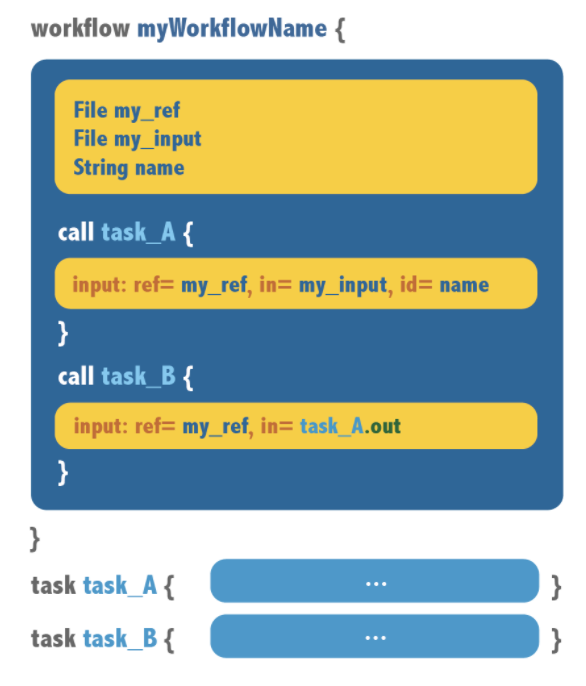

**Structure of task**

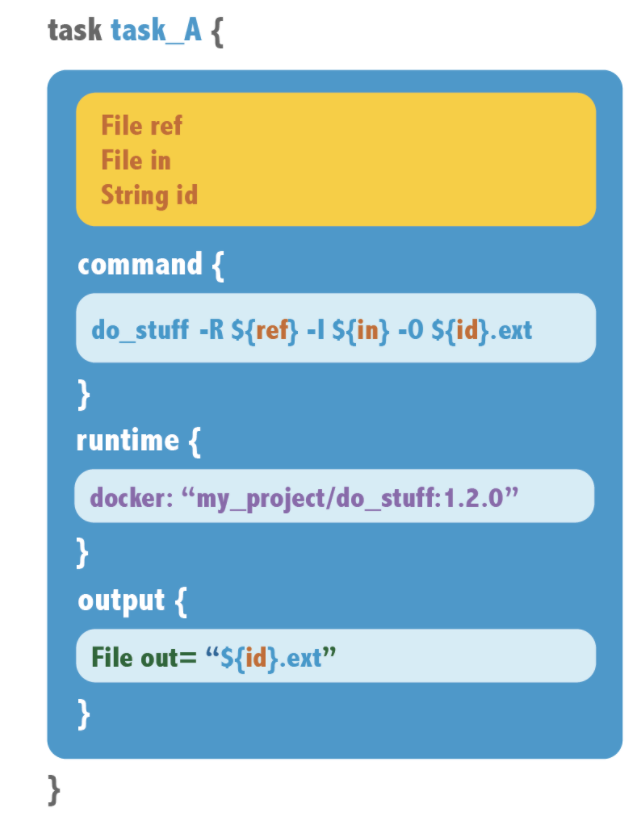

**Scatter-gather** is where you can perform jobs in parallel (instead of sequentially). You run the same task on each input. This is a useful way to make your jobs finish faster.

More useful information about scatter/gather (i.e. running the same process on lots of inputs, e.g. in a GWAS):
* https://support.terra.bio/hc/en-us/articles/360037128572-Scatter-gather-parallelism
* https://support.terra.bio/hc/en-us/articles/360037493811--4-howto-Use-scatter-gather-to-joint-call-genotypes


Illustration of scatter-gather (from https://support.terra.bio/hc/en-us/articles/360037128572-Scatter-gather-parallelism)

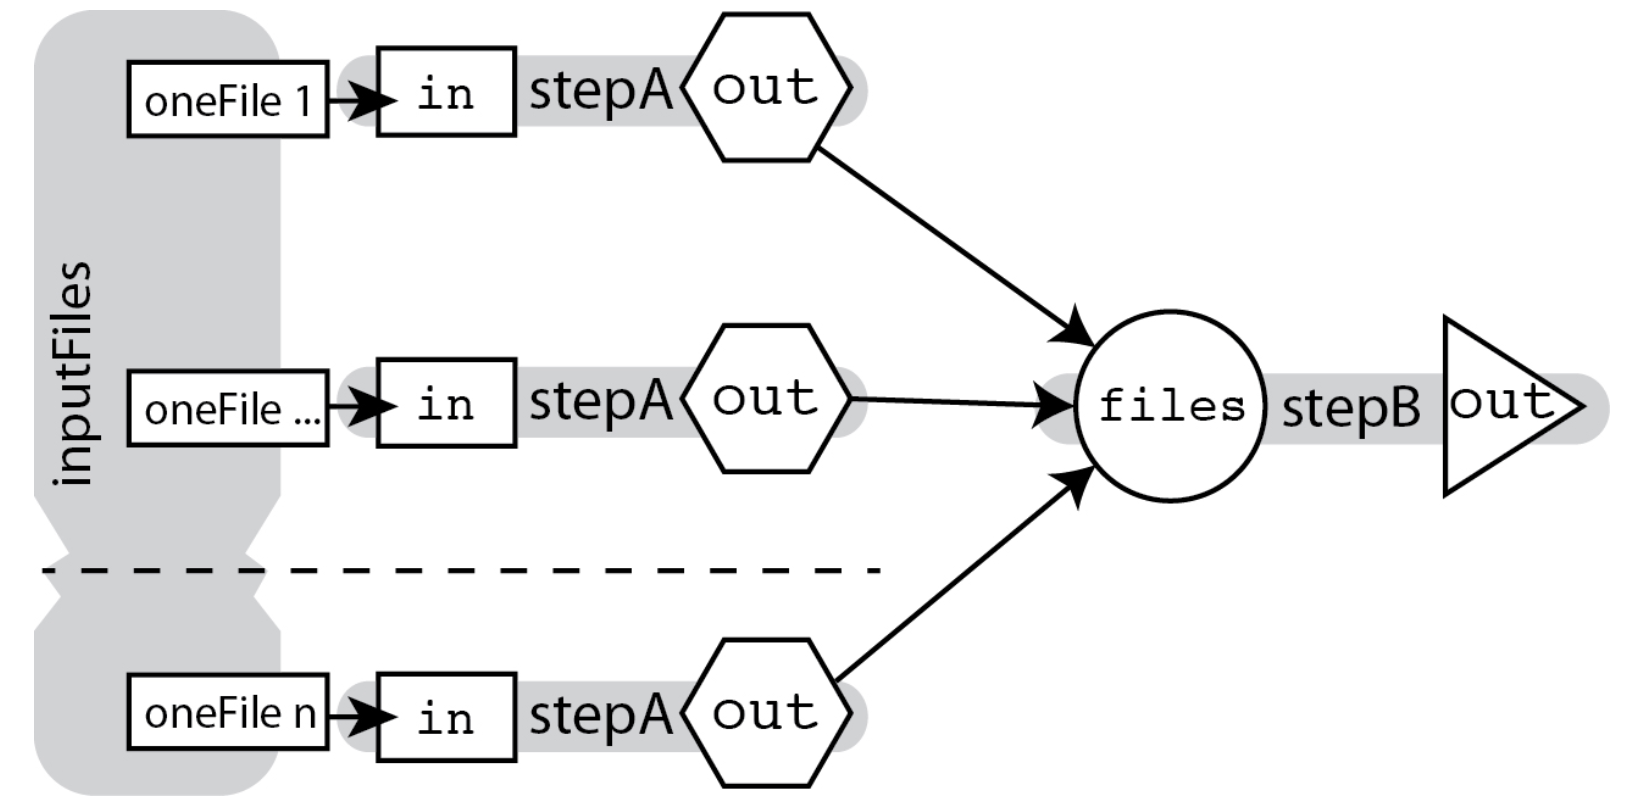

Example of scatter-gather

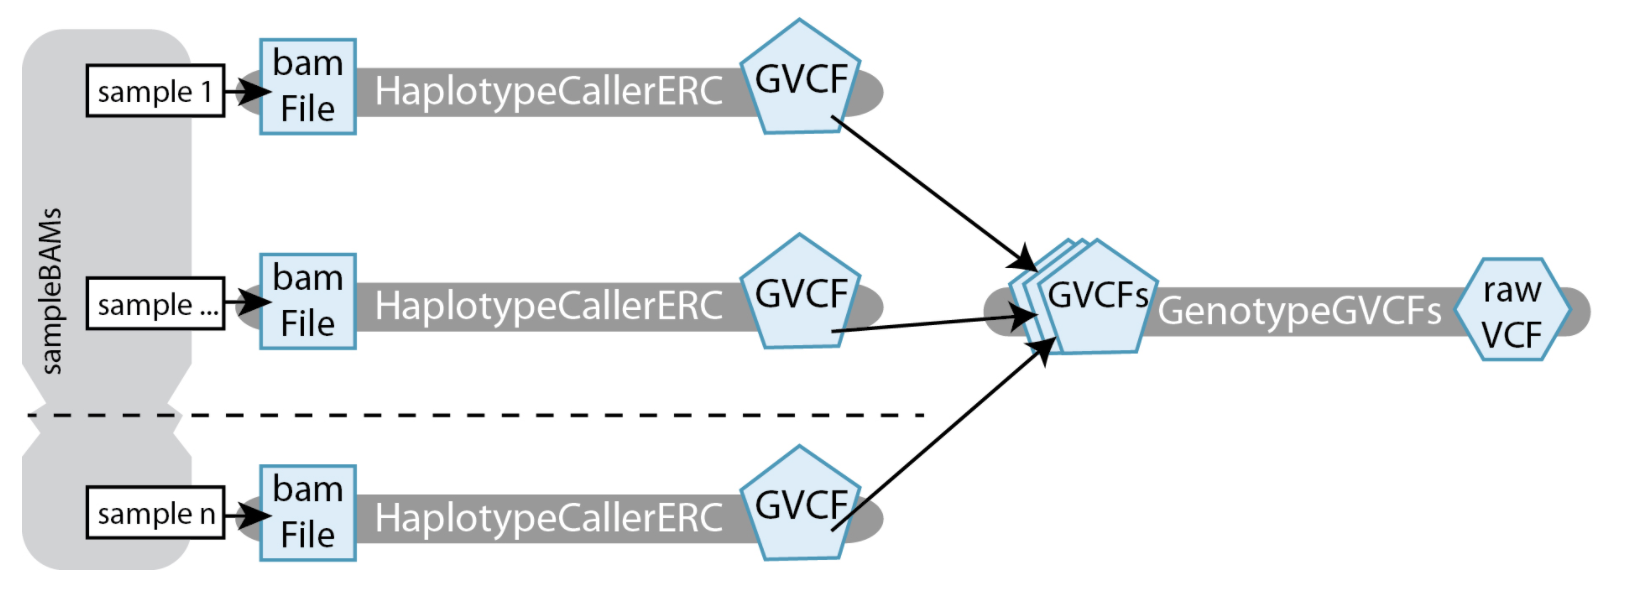

How we are going to use scatter-gather for our progression GWAS:

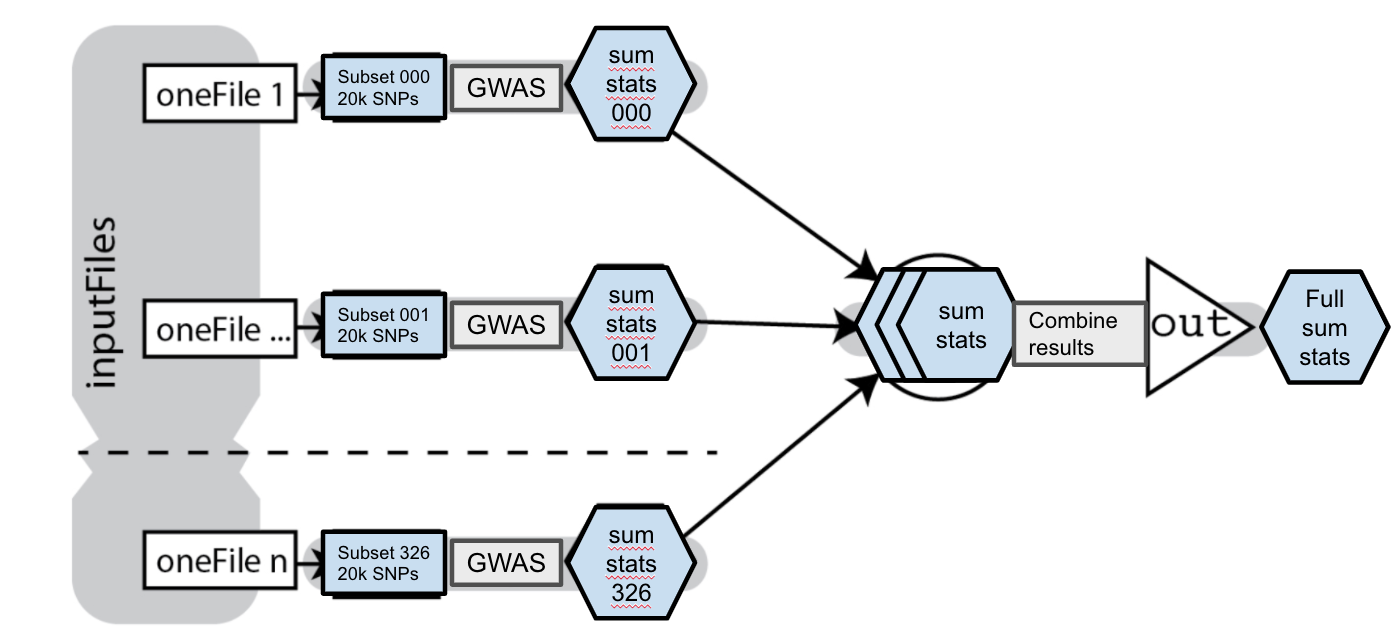

### Run workflow

1. Find a workflow
2. Select Broad Methods Repository
3. Choose a workflow - can be any workflow, but I tried to find a GWAS one that was vaguely similar to what I am trying to do e.g. plink_gwas by Brian Sharber. Or you can create your own Method.
4. Clone that workflow - now you have your own workflow based on that template
5. Edit workflow WDL script
6. Export to workspace
    * Select the workspace you want your workflow to run in
    * Can select ‘Blank configuration’
9. Now back in Terra, put in your input parameters/files (must be in workspace bucket)
10. Save workflow
11. Run workflow
12. If you have errors, check Job History > Job Manager
13. If you need to, edit workflow WDL script in Firecloud - this will update the Snapshot number
14. You can then either export it again and make a new workflow, or just refresh the Workflows page in Terra and select the most updated Snapshot number, Save and Run

## 6. Look at workflow results
<a id="6"></a>

### Import data into notebook

In [19]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/20502268-ca9d-4b30-8bcb-1b1a71feb76c/mixedmodelsGWAS/0a6e4e23-4e70-4a56-8942-e5a5acba45fa/call-combine_results/ALL_results.txt /home/jupyter/progressionGWAS_results/cox')
#File path is taken from the download link in the Data tab

Executing: gsutil -mu terra-9b559320 cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/20502268-ca9d-4b30-8bcb-1b1a71feb76c/mixedmodelsGWAS/0a6e4e23-4e70-4a56-8942-e5a5acba45fa/call-combine_results/ALL_results.txt /home/jupyter/progressionGWAS_results/cox
Copying gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/20502268-ca9d-4b30-8bcb-1b1a71feb76c/mixedmodelsGWAS/0a6e4e23-4e70-4a56-8942-e5a5acba45fa/call-combine_results/ALL_results.txt...
\ [1/1 files][851.0 MiB/851.0 MiB] 100% Done  37.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/851.0 MiB.                                    


In [20]:
%%bash
ls /home/jupyter/progressionGWAS_results/cox

ALL_results.final.txt
ALL_results.txt
test_snps.txt


In [21]:
%%bash
head /home/jupyter/progressionGWAS_results/cox/ALL_results.txt

SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
1:693731	G	107	404	0.518034024032799	0.120549178885662	0.232705137680358	0.604434530670373	0.684922759124544	404	0.0940594059405941
1:715367	G	107	404	-1.6801447145205	-0.859567658143393	0.511603346256221	0.0929291628360286	0.507602026760226	404	0.0396039603960396
1:717485	A	107	404	-1.6801447145205	-0.859567658143393	0.511603346256221	0.0929291628360286	0.507602026760226	404	0.0396039603960396
1:721290	C	107	404	-1.76289097394254	-0.901725951323824	0.511504094497232	0.0779188796666865	0.504526810255506	404	0.0408415841584158
1:726794	G	107	404	-1.53903901417327	-0.788867178964814	0.512571267979566	0.12379477197628	0.507421684159758	404	0.0383663366336634
1:729632	T	107	404	-1.62758480646121	-0.83409548249923	0.512474360284038	0.103612952901245	0.50417408438285	404	0.0396039603960396
1:730087	C	107	404	-0.14515965677161	-0.050570903997742	0.348381259107747	0.884584817725228	0.800382646474359	404	0.047029702970297
1:731718	C	107	404

In [22]:
%%bash
grep SNP /home/jupyter/progressionGWAS_results/cox/ALL_results.txt

SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_EVENTS	N_OBS	Zstat	BETA	SE	P	Coxzph	N	ALT_Frq
SNP	A1	N_E

In [23]:
%%bash
cd /home/jupyter/progressionGWAS_results/cox/
grep -v "SNP" ALL_results.txt > ALL_results.final.txt
wc -l ALL_results.final.txt

6621464 ALL_results.final.txt


### Tidy GWAS results

In [24]:
%%R

results <- fread("/home/jupyter/progressionGWAS_results/cox/ALL_results.final.txt")

colnames(results) <- c("SNP", "A1", "N_EVENTS", "N_OBS", "Zstat", "BETA", "SE", "P", "Coxzph", "N", "ALT_Frq")
head(results)

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

        SNP A1 N_EVENTS N_OBS     Zstat       BETA        SE          P
1: 1:693731  G      107   404  0.518034  0.1205492 0.2327051 0.60443453
2: 1:715367  G      107   404 -1.680145 -0.8595677 0.5116033 0.09292916
3: 1:717485  A      107   404 -1.680145 -0.8595677 0.5116033 0.09292916
4: 1:721290  C      107   404 -1.762891 -0.9017260 0.5115041 0.07791888
5: 1:726794  G      107   404 -1.539039 -0.7888672 0.5125713 0.12379477
6: 1:729632  T      107   404 -1.627585 -0.8340955 0.5124744 0.10361295
      Coxzph   N    ALT_Frq
1: 0.6849228 404 0.09405941
2: 0.5076020 404 0.03960396
3: 0.5076020 404 0.03960396
4: 0.5045268 404 0.04084158
5: 0.5074217 404 0.03836634
6: 0.5041741 404 0.03960396


Congratulations! You have finished your Cox models progression GWAS!